<a href="https://colab.research.google.com/github/vvshyer/tensorflow2.0_learning/blob/master/tf_keras_classification_model_dnn_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0-alpha0

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.3
pandas 0.24.2
sklearn 0.21.1
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [0]:
# x = (x-u)/std
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)

In [0]:
# tf.keras.models.Sequential()
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape = [28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    """
    bn放在激活函数前
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    """
model.add(keras.layers.Dense(10, activation="softmax"))
    
# relu: y=max(0, x)
# softmax: 将向量变为概率分布. x = [x1, x2, x3]
#          y = [e^x1/sum, e^x2/sum, e^x3/sum]
#          sum = e^x1 + e^x2 + e^x3

# 第二种Sequential使用方式：
# model = keras.model.Sequential([
#     keras.layers.Flatten(input_shape = [28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])


# sparse的原因：因为y->index.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = 'sgd',
              metrics = ['accuracy'])


In [0]:
# 第一层: [None, 784] * W + b -> [None, 300]
# W.shape [784, 300], b.shape = [300, 1]

In [7]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs = 10,
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 24s 437us/sample - loss: 1.9400 - accuracy: 0.3588 - val_loss: 1.0553 - val_accuracy: 0.6314
Epoch 2/10
55000/55000 [==============================] - 22s 394us/sample - loss: 1.0764 - accuracy: 0.6268 - val_loss: 0.7805 - val_accuracy: 0.7194
Epoch 3/10
55000/55000 [==============================] - 23s 421us/sample - loss: 0.9408 - accuracy: 0.6666 - val_loss: 0.6906 - val_accuracy: 0.7482
Epoch 4/10
55000/55000 [==============================] - 22s 397us/sample - loss: 0.8635 - accuracy: 0.6951 - val_loss: 0.6311 - val_accuracy: 0.7714
Epoch 5/10
55000/55000 [==============================] - 23s 419us/sample - loss: 0.8104 - accuracy: 0.7109 - val_loss: 0.5932 - val_accuracy: 0.7968
Epoch 6/10
55000/55000 [==============================] - 25s 446us/sample - loss: 0.7739 - accuracy: 0.7255 - val_loss: 0.5625 - val_accuracy: 0.7988
Epoch 7/10
55000/55000 [=====================

In [0]:
!ls

In [0]:
!tensorboard --logdir=callbacks

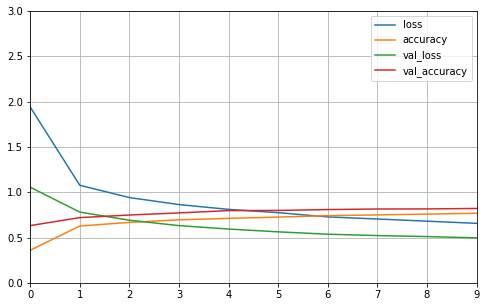

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()
    
plot_learning_curves(history)

In [0]:
# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 原因：链式法则 -> 符合函数f(g(x))
#    批归一化缓解梯度消失

In [10]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 2s 151us/sample - loss: 0.5327 - accuracy: 0.8050


[0.5326743892908097, 0.805]